# Assignment 2 - Gesture Based UI

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# CNN From Scratch - Default Image Colour
Image size = 128 x 128<br/>
Image colour = RGB<br/>



In [29]:
# Define constants
IMAGE_SIZE = (128, 128) #Image size of 128 x 128
BATCH_SIZE = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [30]:
# This code sets up two TensorFlow Keras image datasets for training and validation/testing. The `train_dataset` is created from the 
# `DATASET_PATH` directory, with a 70/30 split for training and validation data. The `validation_and_test_dataset` is also created from
# the `DATASET_PATH` directory, with the same 70/30 split. The `test_dataset` is then created by taking the last 2/3 of the `validation_and_test_dataset`,
# and the `validation_dataset` is created by skipping the last 2/3 of the `validation_and_test_dataset`.
train_dataset = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE)

validation_and_test_dataset = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE)

val_batches = tf.data.experimental.cardinality(validation_and_test_dataset)

test_dataset = validation_and_test_dataset.take((2*val_batches) // 3)
validation_dataset = validation_and_test_dataset.skip((2*val_batches) // 3) 


Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [31]:
# Get the number of classes from the data generator
NUM_CLASSES = len(train_dataset.class_names)
print("Classes: ",NUM_CLASSES)

Classes:  18


In [32]:
# CNN model from scratch
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1],3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)       

In [34]:

# Configures an EarlyStopping callback for a Keras model.

# This callback monitors the validation loss during training and stops the training
# if the validation loss does not improve for 5 epochs. It also restores the
# weights of the model to the best performing weights during training.

# Args:
#     monitor (str): The metric to monitor for early stopping. In this case, it is
#         set to 'val_loss', which means the validation loss.
#     patience (int): The number of epochs to wait before stopping the training if
#         the monitored metric does not improve.
#     restore_best_weights (bool): If True, the model will be restored to the
#         weights that had the best value of the monitored metric.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
# Trains the model on the provided training dataset and evaluates it on the validation dataset. The training runs for 10 epochs and uses the provided callback function to monitor and control the training process.

# Parameters:
# - train_dataset (tf.data.Dataset): The training dataset.
# - validation_dataset (tf.data.Dataset): The validation dataset.
# - epochs (int): The number of training epochs.
# - callbacks (list): A list of callback functions to use during training.
history = model.fit(train_dataset,  validation_data=(validation_dataset), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 49s 18ms/step - loss: 2.7698 - accuracy: 0.0999 - val_loss: 2.6159 - val_accuracy: 0.1390
Epoch 2/10
2755/2755 [==============================] - 29s 11ms/step - loss: 2.5497 - accuracy: 0.1665 - val_loss: 2.4543 - val_accuracy: 0.1932
Epoch 3/10
2755/2755 [==============================] - 29s 11ms/step - loss: 2.3850 - accuracy: 0.2229 - val_loss: 2.3162 - val_accuracy: 0.2426
Epoch 4/10
2755/2755 [==============================] - 30s 11ms/step - loss: 2.2069 - accuracy: 0.2825 - val_loss: 2.1625 - val_accuracy: 0.3068
Epoch 5/10
2755/2755 [==============================] - 29s 11ms/step - loss: 2.0186 - accuracy: 0.3447 - val_loss: 1.9549 - val_accuracy: 0.3643
Epoch 6/10
2755/2755 [==============================] - 29s 11ms/step - loss: 1.8561 - accuracy: 0.3938 - val_loss: 1.8174 - val_accuracy: 0.3961
Epoch 7/10
2755/2755 [==============================] - 29s 11ms/step - loss: 1.7146 - accuracy: 0.4372 - val_loss: 1.6389 -

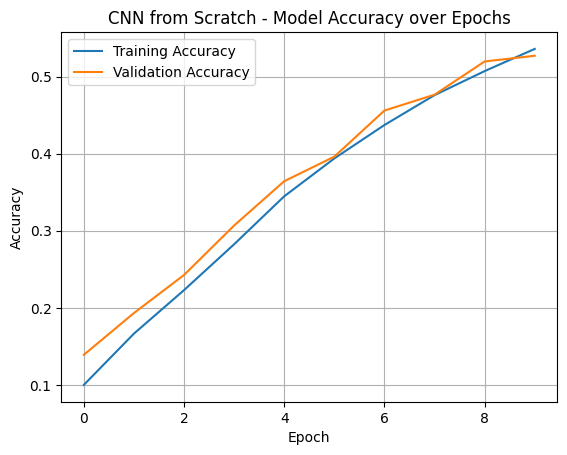

In [36]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN from Scratch - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Evaluates the model on the test dataset and returns a dictionary of evaluation metrics.
model.evaluate(test_dataset, return_dict=True)

787/787 [==============================] - 5s 6ms/step - loss: 1.4050 - accuracy: 0.5424


{'loss': 1.40500009059906, 'accuracy': 0.5423681735992432}

In [38]:
class_names = train_dataset.class_names

# Prediction of My Hand Peace
my_image1 = np.array(Image.open("MyHandPeace.jpg").resize((IMAGE_SIZE[0],IMAGE_SIZE[1])))
my_image1 = my_image1.reshape(1,IMAGE_SIZE[0],IMAGE_SIZE[1],3)
prediction_of_my_image = model.predict(my_image1)
my_image1_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My hand Palm
my_image2 = np.array(Image.open("MyHandPalm.jpg").resize((IMAGE_SIZE[0],IMAGE_SIZE[1])))
my_image2 = my_image2.reshape(1,IMAGE_SIZE[0],IMAGE_SIZE[1],3)
prediction_of_my_image = model.predict(my_image2)
my_image2_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My Hand Stop 
my_image3 = np.array(Image.open("MyHandStop.jpg").resize((IMAGE_SIZE[0],IMAGE_SIZE[1])))
my_image3 = my_image3.reshape(1,IMAGE_SIZE[0],IMAGE_SIZE[1],3)
prediction_of_my_image = model.predict(my_image3)
my_image3_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My Hand Two Up
my_image4 = np.array(Image.open("MyHandTwoUp.jpg").resize((IMAGE_SIZE[0],IMAGE_SIZE[1])))
my_image4 = my_image4.reshape(1,IMAGE_SIZE[0],IMAGE_SIZE[1],3)
prediction_of_my_image = model.predict(my_image4)
my_image4_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Print the predicted class names
print("Predicted Class for MyHandPeace.jpg   (Should predict peace): ", my_image1_prediction)
print("Predicted Class for MyHandPalm.jpg     (Should predict Palm): ", my_image2_prediction)
print("Predicted Class for MyHandStop.jpg     (Should predict Stop): ", my_image3_prediction)
print("Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up): ", my_image4_prediction)


1/1 [==============================] - 0s 10ms/step
Predicted Class for MyHandPeace.jpg   (Should predict peace):  peace
Predicted Class for MyHandPalm.jpg     (Should predict Palm):  palm
Predicted Class for MyHandStop.jpg     (Should predict Stop):  stop
Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up):  two_up


# CNN from Scratch - RGB Images - More Convolutional Layers and Increased Filters

- The previous model doesn't have a great accuracy, lets try and improve it by adding some layers and increasing the filters in the convolutional layers

In [47]:
# Define constants
IMAGE_SIZE1 = (128, 128) #Image size of 128 x 128
BATCH_SIZE1 = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [48]:
train_dataset1 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE1, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE1)

validation_and_test_dataset1 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE1, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE1)

val_batches1 = tf.data.experimental.cardinality(validation_and_test_dataset1)

test_dataset1 = validation_and_test_dataset1.take((2*val_batches1) // 3)
validation_dataset1 = validation_and_test_dataset1.skip((2*val_batches1) // 3) 


Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [49]:
# Get the number of classes from the data generator
NUM_CLASSES = len(train_dataset1.class_names)
print("Classes: ",NUM_CLASSES)

Classes:  18


In [50]:
# CNN model from scratch
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.Input(shape=(IMAGE_SIZE1[0], IMAGE_SIZE1[1],3)))
model1.add(layers.Rescaling(1./255))
model1.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [51]:
#model1.fit(train_dataset1,  validation_data=(validation_dataset1), epochs=10, callbacks=[callback])
history1 = model1.fit(train_dataset1, validation_data=(validation_dataset1), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 73s 26ms/step - loss: 2.7080 - accuracy: 0.1159 - val_loss: 2.4164 - val_accuracy: 0.2177
Epoch 2/10
2755/2755 [==============================] - 79s 29ms/step - loss: 2.0148 - accuracy: 0.3438 - val_loss: 1.5731 - val_accuracy: 0.4866
Epoch 3/10
2755/2755 [==============================] - 119s 43ms/step - loss: 1.3258 - accuracy: 0.5694 - val_loss: 1.1286 - val_accuracy: 0.6423
Epoch 4/10
2755/2755 [==============================] - 144s 52ms/step - loss: 0.9917 - accuracy: 0.6810 - val_loss: 0.9166 - val_accuracy: 0.7088
Epoch 5/10
2755/2755 [==============================] - 74s 27ms/step - loss: 0.8240 - accuracy: 0.7366 - val_loss: 0.8069 - val_accuracy: 0.7433
Epoch 6/10
2755/2755 [==============================] - 92s 33ms/step - loss: 0.7069 - accuracy: 0.7736 - val_loss: 0.7009 - val_accuracy: 0.7762
Epoch 7/10
2755/2755 [==============================] - 91s 33ms/step - loss: 0.6244 - accuracy: 0.7986 - val_loss: 0.6240

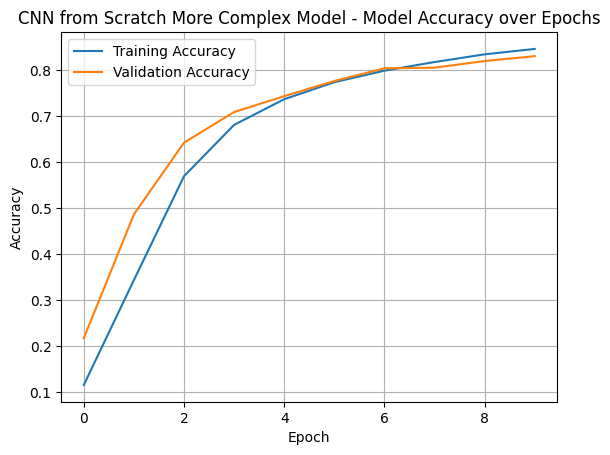

In [52]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN from Scratch More Complex Model - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
model1.evaluate(test_dataset1, return_dict=True)

787/787 [==============================] - 46s 58ms/step - loss: 0.5423 - accuracy: 0.8306


{'loss': 0.5423401594161987, 'accuracy': 0.8306067585945129}

In [54]:
class_names = train_dataset1.class_names

# Prediction of My Hand Peace
my_image1 = np.array(Image.open("MyHandPeace.jpg").resize((IMAGE_SIZE1[0],IMAGE_SIZE1[1])))
my_image1 = my_image1.reshape(1,IMAGE_SIZE1[0],IMAGE_SIZE1[1],3)
prediction_of_my_image = model1.predict(my_image1)
my_image1_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My hand Palm
my_image2 = np.array(Image.open("MyHandPalm.jpg").resize((IMAGE_SIZE1[0],IMAGE_SIZE1[1])))
my_image2 = my_image2.reshape(1,IMAGE_SIZE1[0],IMAGE_SIZE1[1],3)
prediction_of_my_image = model1.predict(my_image2)
my_image2_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My Hand Stop 
my_image3 = np.array(Image.open("MyHandStop.jpg").resize((IMAGE_SIZE1[0],IMAGE_SIZE1[1])))
my_image3 = my_image3.reshape(1,IMAGE_SIZE1[0],IMAGE_SIZE1[1],3)
prediction_of_my_image = model1.predict(my_image3)
my_image3_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My Hand Two Up
my_image4 = np.array(Image.open("MyHandTwoUp.jpg").resize((IMAGE_SIZE1[0],IMAGE_SIZE1[1])))
my_image4 = my_image4.reshape(1,IMAGE_SIZE1[0],IMAGE_SIZE1[1],3)
prediction_of_my_image = model1.predict(my_image4)
my_image4_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Print the predicted class names
print("Predicted Class for MyHandPeace.jpg   (Should predict peace): ", my_image1_prediction)
print("Predicted Class for MyHandPalm.jpg     (Should predict Palm): ", my_image2_prediction)
print("Predicted Class for MyHandStop.jpg     (Should predict Stop): ", my_image3_prediction)
print("Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up): ", my_image4_prediction)


1/1 [==============================] - 0s 10ms/step
Predicted Class for MyHandPeace.jpg   (Should predict peace):  peace
Predicted Class for MyHandPalm.jpg     (Should predict Palm):  palm
Predicted Class for MyHandStop.jpg     (Should predict Stop):  stop
Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up):  two_up


# CNN from Scatch - Grayscale Images

In [55]:
# Define constants
IMAGE_SIZE2 = (128, 128) #Image size of 128 x 128
BATCH_SIZE2 = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [56]:
# This code sets up two TensorFlow Keras image datasets for training and validation/testing. The `train_dataset` is created from the 
# `DATASET_PATH` directory, with a 70/30 split for training and validation data. The `validation_and_test_dataset` is also created from
# the `DATASET_PATH` directory, with the same 70/30 split. The `test_dataset` is then created by taking the last 2/3 of the `validation_and_test_dataset`,
# and the `validation_dataset` is created by skipping the last 2/3 of the `validation_and_test_dataset`.
train_dataset_grayscale = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            color_mode = "grayscale",
                                                            image_size=IMAGE_SIZE2, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE2)
NUM_CLASSES = len(train_dataset_grayscale.class_names)
CLASS_NAMES = train_dataset_grayscale.class_names

validation_and_test_dataset_grayscale = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            color_mode="grayscale",
                                                            image_size=IMAGE_SIZE2, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE2)

val_batches = tf.data.experimental.cardinality(validation_and_test_dataset_grayscale)

test_dataset_grayscale = validation_and_test_dataset_grayscale.take((2*val_batches) // 3)

validation_dataset_grayscale = validation_and_test_dataset_grayscale.skip((2*val_batches) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [57]:
# CNN model from scratch
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.Input(shape=(IMAGE_SIZE2[0], IMAGE_SIZE2[1],1)))
model2.add(layers.Rescaling(1./255))
model2.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


flatten had it over fitting

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [59]:
history2 = model2.fit(train_dataset_grayscale,  validation_data=(validation_dataset_grayscale), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 43s 16ms/step - loss: 2.8905 - accuracy: 0.0579 - val_loss: 2.8905 - val_accuracy: 0.0549
Epoch 2/10
2755/2755 [==============================] - 36s 13ms/step - loss: 2.8904 - accuracy: 0.0585 - val_loss: 2.8906 - val_accuracy: 0.0550
Epoch 3/10
2755/2755 [==============================] - 35s 13ms/step - loss: 2.8904 - accuracy: 0.0582 - val_loss: 2.8906 - val_accuracy: 0.0550
Epoch 4/10
2755/2755 [==============================] - 36s 13ms/step - loss: 2.8904 - accuracy: 0.0582 - val_loss: 2.8906 - val_accuracy: 0.0548
Epoch 5/10
2755/2755 [==============================] - 40s 14ms/step - loss: 2.8904 - accuracy: 0.0583 - val_loss: 2.8906 - val_accuracy: 0.0548
Epoch 6/10
2755/2755 [==============================] - 37s 13ms/step - loss: 2.8904 - accuracy: 0.0584 - val_loss: 2.8906 - val_accuracy: 0.0548


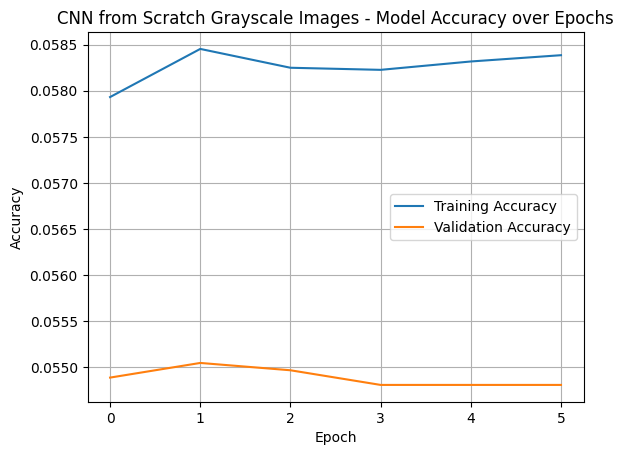

In [60]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN from Scratch Grayscale Images - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 48)       

In [62]:
model2.evaluate(test_dataset_grayscale, return_dict=True)

787/787 [==============================] - 5s 6ms/step - loss: 2.8904 - accuracy: 0.0581


{'loss': 2.8904147148132324, 'accuracy': 0.05805273354053497}

In [ ]:
# Load and preprocess the image
my_image1 = Image.open("MyHandStop.jpg").resize((IMAGE_SIZE2[0], IMAGE_SIZE2[1]))
my_image2 = Image.open("MyHandPeace.jpg").resize((IMAGE_SIZE2[0], IMAGE_SIZE2[1]))
my_image3 = Image.open("MyHandTwoUp.jpg").resize((IMAGE_SIZE2[0], IMAGE_SIZE2[1]))
my_image4 = Image.open("MyHandPalm.jpg").resize((IMAGE_SIZE2[0], IMAGE_SIZE2[1]))
# Convert the image to grayscale if necessary
my_image1 = my_image1.convert("L")
my_image2 = my_image2.convert("L")
my_image3 = my_image3.convert("L")
my_image4 = my_image4.convert("L")
# Convert the image to numpy array
my_image_array1 = np.array(my_image1)
my_image_array2 = np.array(my_image2)
my_image_array3 = np.array(my_image3)
my_image_array4 = np.array(my_image4)
# Expand dimensions to match the model's input shape
my_image_array1 = np.expand_dims(my_image_array1, axis=0)
my_image_array1 = np.expand_dims(my_image_array1, axis=-1)

my_image_array2 = np.expand_dims(my_image_array2, axis=0)
my_image_array2 = np.expand_dims(my_image_array2, axis=-1)

my_image_array3 = np.expand_dims(my_image_array3, axis=0)
my_image_array3 = np.expand_dims(my_image_array3, axis=-1)

my_image_array4 = np.expand_dims(my_image_array4, axis=0)
my_image_array4 = np.expand_dims(my_image_array4, axis=-1)
# Predict the class probabilities
prediction_of_my_image1 = model2.predict(my_image_array1)
prediction_of_my_image2 = model2.predict(my_image_array2)
prediction_of_my_image3 = model2.predict(my_image_array3)
prediction_of_my_image4 = model2.predict(my_image_array4)
# Get the index of the predicted class (the class with the highest probability)
predicted_class_index1 = np.argmax(prediction_of_my_image1)
predicted_class_index2 = np.argmax(prediction_of_my_image2)
predicted_class_index3 = np.argmax(prediction_of_my_image3)
predicted_class_index4 = np.argmax(prediction_of_my_image4)
# Map the predicted class index to the corresponding class name


predicted_class_name1 = CLASS_NAMES[predicted_class_index1]
predicted_class_name2 = CLASS_NAMES[predicted_class_index2]
predicted_class_name3 = CLASS_NAMES[predicted_class_index3]
predicted_class_name4 = CLASS_NAMES[predicted_class_index4]

print("Predicted Class for MyHandPeace.jpg   (Should predict peace): ", predicted_class_name2)
print("Predicted Class for MyHandPalm.jpg     (Should predict Palm): ", predicted_class_name4)
print("Predicted Class for MyHandStop.jpg     (Should predict Stop): ", predicted_class_name1)
print("Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up): ", predicted_class_name3)

# CNN from Scratch - Smaller Images, Data Augmentation

In [83]:
# Define constants
IMAGE_SIZE3 = (128, 128) #Image size of 128 x 128
BATCH_SIZE3 = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [84]:
# This code sets up two TensorFlow Keras image datasets for training and validation/testing. The `train_dataset` is created from the 
# `DATASET_PATH` directory, with a 70/30 split for training and validation data. The `validation_and_test_dataset` is also created from
# the `DATASET_PATH` directory, with the same 70/30 split. The `test_dataset` is then created by taking the last 2/3 of the `validation_and_test_dataset`,
# and the `validation_dataset` is created by skipping the last 2/3 of the `validation_and_test_dataset`.
train_dataset3 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE3, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE3)
NUM_CLASSES = len(train_dataset3.class_names)
CLASS_NAMES = train_dataset3.class_names

validation_and_test_dataset3 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE3, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE3)

val_batches3 = tf.data.experimental.cardinality(validation_and_test_dataset3)

test_dataset3 = validation_and_test_dataset3.take((2*val_batches3) // 3)

validation_dataset3 = validation_and_test_dataset3.skip((2*val_batches3) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [85]:
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [86]:
# CNN model from scratch
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.Input(shape=(IMAGE_SIZE3[0], IMAGE_SIZE3[1],3)))
model3.add(data_augmentation_layers)
model3.add(layers.Rescaling(1./255))
model3.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [87]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [88]:
history3 = model3.fit(train_dataset3,  validation_data=(validation_dataset3), epochs=10, callbacks=[callback])

Epoch 1/10
2755/2755 [==============================] - 158s 57ms/step - loss: 2.7854 - accuracy: 0.0944 - val_loss: 2.6306 - val_accuracy: 0.1443
Epoch 2/10
2755/2755 [==============================] - 155s 56ms/step - loss: 2.2919 - accuracy: 0.2573 - val_loss: 1.7780 - val_accuracy: 0.4214
Epoch 3/10
2755/2755 [==============================] - 166s 60ms/step - loss: 1.6935 - accuracy: 0.4514 - val_loss: 1.3657 - val_accuracy: 0.5591
Epoch 4/10
2755/2755 [==============================] - 465s 169ms/step - loss: 1.3743 - accuracy: 0.5542 - val_loss: 1.1268 - val_accuracy: 0.6398
Epoch 5/10
2755/2755 [==============================] - 634s 230ms/step - loss: 1.1702 - accuracy: 0.6203 - val_loss: 0.9648 - val_accuracy: 0.6878
Epoch 6/10
2755/2755 [==============================] - 652s 237ms/step - loss: 1.0274 - accuracy: 0.6680 - val_loss: 0.8594 - val_accuracy: 0.7193
Epoch 7/10
2755/2755 [==============================] - 570s 207ms/step - loss: 0.9186 - accuracy: 0.7023 - val_los

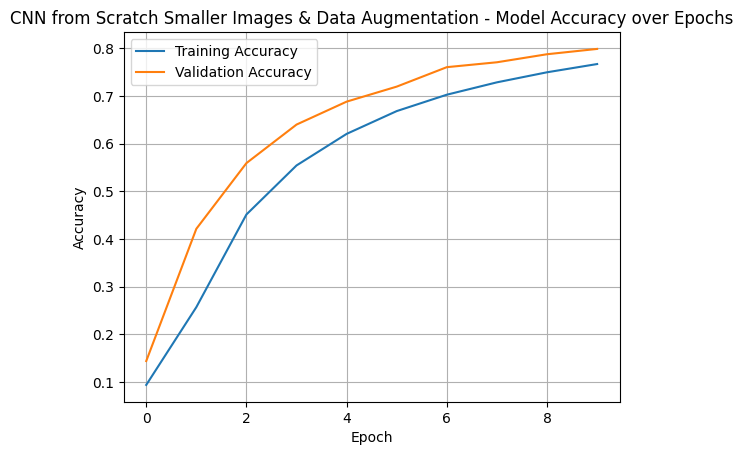

In [91]:
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN from Scratch Smaller Images & Data Augmentation - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
model3.evaluate(test_dataset3, return_dict=True)

787/787 [==============================] - 23s 29ms/step - loss: 0.6247 - accuracy: 0.7976


{'loss': 0.6247223019599915, 'accuracy': 0.7976095676422119}

In [ ]:
class_names = train_dataset3.class_names

# Prediction of My Hand Peace
my_image1 = np.array(Image.open("MyHandPeace.jpg").resize((IMAGE_SIZE3[0],IMAGE_SIZE3[1])))
my_image1 = my_image1.reshape(1,IMAGE_SIZE3[0],IMAGE_SIZE3[1],3)
prediction_of_my_image = model3.predict(my_image1)
my_image1_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My hand Palm
my_image2 = np.array(Image.open("MyHandPalm.jpg").resize((IMAGE_SIZE3[0],IMAGE_SIZE3[1])))
my_image2 = my_image2.reshape(1,IMAGE_SIZE3[0],IMAGE_SIZE3[1],3)
prediction_of_my_image = model3.predict(my_image2)
my_image2_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My Hand Stop 
my_image3 = np.array(Image.open("MyHandStop.jpg").resize((IMAGE_SIZE3[0],IMAGE_SIZE3[1])))
my_image3 = my_image3.reshape(1,IMAGE_SIZE3[0],IMAGE_SIZE3[1],3)
prediction_of_my_image = model3.predict(my_image3)
my_image3_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Prediction of My Hand Two Up
my_image4 = np.array(Image.open("MyHandTwoUp.jpg").resize((IMAGE_SIZE3[0],IMAGE_SIZE3[1])))
my_image4 = my_image4.reshape(1,IMAGE_SIZE3[0],IMAGE_SIZE3[1],3)
prediction_of_my_image = model3.predict(my_image4)
my_image4_prediction = pd.DataFrame(prediction_of_my_image, columns=class_names).idxmax(axis=1).iloc[0]

# Print the predicted class names
print("Predicted Class for MyHandPeace.jpg   (Should predict peace): ", my_image1_prediction)
print("Predicted Class for MyHandPalm.jpg     (Should predict Palm): ", my_image2_prediction)
print("Predicted Class for MyHandStop.jpg     (Should predict Stop): ", my_image3_prediction)
print("Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up): ", my_image4_prediction)


# Transfer Learning - 224 Image Size with Data Augmentation

In [93]:
# Define constants
IMAGE_SIZE_TRANSFERLEARNING = (224, 224) #Image size of 224 x 224
BATCH_SIZE_TF = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [94]:
# This code sets up two TensorFlow Keras image datasets for training and validation/testing. The `train_dataset` is created from the 
# `DATASET_PATH` directory, with a 70/30 split for training and validation data. The `validation_and_test_dataset` is also created from
# the `DATASET_PATH` directory, with the same 70/30 split. The `test_dataset` is then created by taking the last 2/3 of the `validation_and_test_dataset`,
# and the `validation_dataset` is created by skipping the last 2/3 of the `validation_and_test_dataset`.
train_datasettf = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE_TRANSFERLEARNING, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE_TF)
NUM_CLASSES_TF = len(train_datasettf.class_names)
CLASS_NAMES_TF = train_datasettf.class_names

validation_and_test_datasettf = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE_TRANSFERLEARNING, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE_TF)

val_batchestf = tf.data.experimental.cardinality(validation_and_test_datasettf)

test_datasettf = validation_and_test_datasettf.take((2*val_batchestf) // 3)

validation_datasettf = validation_and_test_datasettf.skip((2*val_batchestf) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [95]:
data_augmentation_layerstf = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [96]:
inputs = tf.keras.Input(shape=(IMAGE_SIZE_TRANSFERLEARNING[0], IMAGE_SIZE_TRANSFERLEARNING[1],3))

In [97]:
model_transferlearning = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMAGE_SIZE_TRANSFERLEARNING[0], IMAGE_SIZE_TRANSFERLEARNING[1],3),
    include_top=False)

model_transferlearning.trainable = False
x = data_augmentation_layerstf(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model_transferlearning(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES_TF)(x)
modeltf = tf.keras.Model(inputs, outputs)

In [98]:
modeltf.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [99]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [101]:
historytf = modeltf.fit(train_datasettf,  validation_data=(validation_datasettf), epochs=5, callbacks=[callback])

Epoch 1/5
2755/2755 [==============================] - 731s 254ms/step - loss: 2.3857 - accuracy: 0.3425 - val_loss: 1.4583 - val_accuracy: 0.5313
Epoch 2/5
2755/2755 [==============================] - 2104s 763ms/step - loss: 1.9262 - accuracy: 0.4131 - val_loss: 1.4936 - val_accuracy: 0.5250
Epoch 3/5
2755/2755 [==============================] - 1825s 662ms/step - loss: 1.9238 - accuracy: 0.4151 - val_loss: 1.5152 - val_accuracy: 0.5184
Epoch 4/5
2755/2755 [==============================] - 782s 284ms/step - loss: 1.9230 - accuracy: 0.4153 - val_loss: 1.5061 - val_accuracy: 0.5243
Epoch 5/5
2755/2755 [==============================] - 479s 174ms/step - loss: 1.9297 - accuracy: 0.4138 - val_loss: 1.5170 - val_accuracy: 0.5197


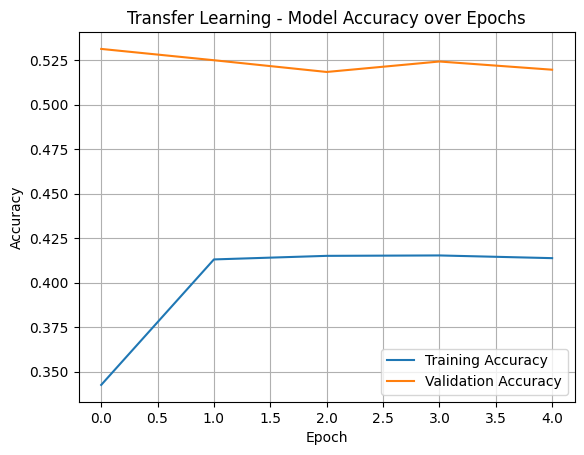

In [102]:
plt.plot(historytf.history['accuracy'], label='Training Accuracy')
plt.plot(historytf.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
modeltf.evaluate(test_datasettf, return_dict=True)

787/787 [==============================] - 57s 72ms/step - loss: 1.5192 - accuracy: 0.5216


{'loss': 1.5191808938980103, 'accuracy': 0.5216010212898254}

In [104]:
class_namestf = train_datasettf.class_names

# Prediction of My Hand Peace
my_image1 = np.array(Image.open("MyHandPeace.jpg").resize((IMAGE_SIZE_TRANSFERLEARNING[0],IMAGE_SIZE_TRANSFERLEARNING[1])))
my_image1 = my_image1.reshape(1,IMAGE_SIZE_TRANSFERLEARNING[0],IMAGE_SIZE_TRANSFERLEARNING[1],3)
prediction_of_my_image = modeltf.predict(my_image1)
my_image1_prediction = pd.DataFrame(prediction_of_my_image, columns=class_namestf).idxmax(axis=1).iloc[0]

# Prediction of My hand Palm
my_image2 = np.array(Image.open("MyHandPalm.jpg").resize((IMAGE_SIZE_TRANSFERLEARNING[0],IMAGE_SIZE_TRANSFERLEARNING[1])))
my_image2 = my_image2.reshape(1,IMAGE_SIZE_TRANSFERLEARNING[0],IMAGE_SIZE_TRANSFERLEARNING[1],3)
prediction_of_my_image = modeltf.predict(my_image2)
my_image2_prediction = pd.DataFrame(prediction_of_my_image, columns=class_namestf).idxmax(axis=1).iloc[0]

# Prediction of My Hand Stop 
my_image3 = np.array(Image.open("MyHandStop.jpg").resize((IMAGE_SIZE_TRANSFERLEARNING[0],IMAGE_SIZE_TRANSFERLEARNING[1])))
my_image3 = my_image3.reshape(1,IMAGE_SIZE_TRANSFERLEARNING[0],IMAGE_SIZE_TRANSFERLEARNING[1],3)
prediction_of_my_image = modeltf.predict(my_image3)
my_image3_prediction = pd.DataFrame(prediction_of_my_image, columns=class_namestf).idxmax(axis=1).iloc[0]

# Prediction of My Hand Two Up
my_image4 = np.array(Image.open("MyHandTwoUp.jpg").resize((IMAGE_SIZE_TRANSFERLEARNING[0],IMAGE_SIZE_TRANSFERLEARNING[1])))
my_image4 = my_image4.reshape(1,IMAGE_SIZE_TRANSFERLEARNING[0],IMAGE_SIZE_TRANSFERLEARNING[1],3)
prediction_of_my_image = modeltf.predict(my_image4)
my_image4_prediction = pd.DataFrame(prediction_of_my_image, columns=class_namestf).idxmax(axis=1).iloc[0]

# Print the predicted class names
print("Predicted Class for MyHandPeace.jpg   (Should predict peace): ", my_image1_prediction)
print("Predicted Class for MyHandPalm.jpg     (Should predict Palm): ", my_image2_prediction)
print("Predicted Class for MyHandStop.jpg     (Should predict Stop): ", my_image3_prediction)
print("Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up): ", my_image4_prediction)

1/1 [==============================] - 0s 12ms/step
Predicted Class for MyHandPeace.jpg   (Should predict peace):  peace
Predicted Class for MyHandPalm.jpg     (Should predict Palm):  three2
Predicted Class for MyHandStop.jpg     (Should predict Stop):  stop
Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up):  fist


# Transfer Learning - 224x224 with Data Augmentation and unfreezing the last two layers


In [105]:
# Define constants
IMAGE_SIZE_TRANSFERLEARNING1 = (224, 224) #Image size of 128 x 128
BATCH_SIZE_TF1 = 32
DATASET_PATH = "hagridset"
SEED = 399177 #G00399177

In [106]:
train_datasettf1 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE_TRANSFERLEARNING1, validation_split=0.3
                                                           , subset='training', label_mode='categorical', 
                                                           seed=SEED, batch_size=BATCH_SIZE_TF1)
NUM_CLASSES_TF = len(train_datasettf1.class_names)
CLASS_NAMES_TF = train_datasettf1.class_names

validation_and_test_datasettf1 = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                            shuffle=True,
                                                            image_size=IMAGE_SIZE_TRANSFERLEARNING1, validation_split=0.3
                                                           , subset='validation',label_mode='categorical',
                                                           seed=SEED, batch_size=BATCH_SIZE_TF1)

val_batchestf1 = tf.data.experimental.cardinality(validation_and_test_datasettf1)

test_datasettf1 = validation_and_test_datasettf1.take((2*val_batchestf1) // 3)

validation_datasettf1 = validation_and_test_datasettf1.skip((2*val_batchestf1) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [107]:
data_augmentation_layerstf1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [108]:
inputs1 = tf.keras.Input(shape=(IMAGE_SIZE_TRANSFERLEARNING1[0], IMAGE_SIZE_TRANSFERLEARNING1[1],3))

In [109]:
model_transferlearning1 = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMAGE_SIZE_TRANSFERLEARNING1[0], IMAGE_SIZE_TRANSFERLEARNING1[1],3),
    include_top=False)

# Unfreeze the last 2 layers for fine tuning
for layer in model_transferlearning1.layers[:-2]:
    layer.trainable = False
for layer in model_transferlearning1.layers[-2:]:
    layer.trainable = True

x = data_augmentation_layerstf1(inputs1)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model_transferlearning1(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs1 = tf.keras.layers.Dense(NUM_CLASSES_TF)(x)
modeltf1 = tf.keras.Model(inputs1, outputs1)

In [110]:
modeltf1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [112]:
historytf1 = modeltf1.fit(train_datasettf1,  validation_data=(validation_datasettf1), epochs=5, callbacks=[callback])

Epoch 1/5
2755/2755 [==============================] - 340s 123ms/step - loss: 0.9042 - accuracy: 0.7203 - val_loss: 0.3947 - val_accuracy: 0.8711
Epoch 2/5
2755/2755 [==============================] - 337s 122ms/step - loss: 0.5452 - accuracy: 0.8236 - val_loss: 0.3232 - val_accuracy: 0.9010
Epoch 3/5
2755/2755 [==============================] - 337s 122ms/step - loss: 0.4744 - accuracy: 0.8460 - val_loss: 0.2971 - val_accuracy: 0.9063
Epoch 4/5
2755/2755 [==============================] - 337s 122ms/step - loss: 0.4363 - accuracy: 0.8590 - val_loss: 0.2878 - val_accuracy: 0.9079
Epoch 5/5
2755/2755 [==============================] - 337s 122ms/step - loss: 0.4145 - accuracy: 0.8662 - val_loss: 0.2702 - val_accuracy: 0.9168


In [113]:
modeltf1.evaluate(test_datasettf1, return_dict=True)

787/787 [==============================] - 60s 76ms/step - loss: 0.2727 - accuracy: 0.9169


{'loss': 0.2727057933807373, 'accuracy': 0.9168916940689087}

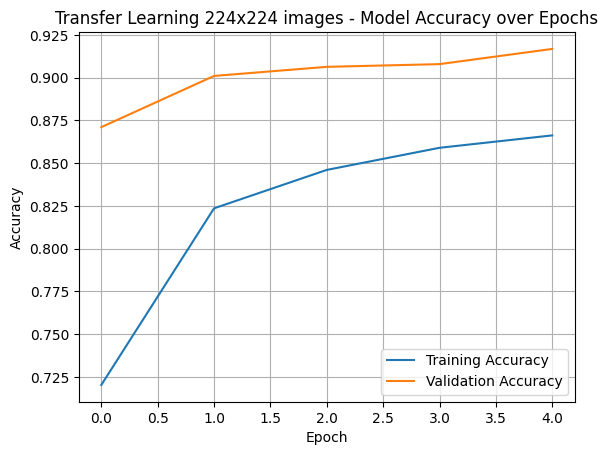

In [114]:
plt.plot(historytf1.history['accuracy'], label='Training Accuracy')
plt.plot(historytf1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning 224x224 images - Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [116]:
class_namestf1 = train_datasettf1.class_names

# Prediction of My Hand Peace
my_image1 = np.array(Image.open("MyHandPeace.jpg").resize((IMAGE_SIZE_TRANSFERLEARNING1[0],IMAGE_SIZE_TRANSFERLEARNING1[1])))
my_image1 = my_image1.reshape(1,IMAGE_SIZE_TRANSFERLEARNING1[0],IMAGE_SIZE_TRANSFERLEARNING1[1],3)
prediction_of_my_image = modeltf1.predict(my_image1)
my_image1_prediction = pd.DataFrame(prediction_of_my_image, columns=class_namestf1).idxmax(axis=1).iloc[0]

# Prediction of My hand Palm
my_image2 = np.array(Image.open("MyHandPalm.jpg").resize((IMAGE_SIZE_TRANSFERLEARNING1[0],IMAGE_SIZE_TRANSFERLEARNING1[1])))
my_image2 = my_image2.reshape(1,IMAGE_SIZE_TRANSFERLEARNING1[0],IMAGE_SIZE_TRANSFERLEARNING1[1],3)
prediction_of_my_image = modeltf1.predict(my_image2)
my_image2_prediction = pd.DataFrame(prediction_of_my_image, columns=class_namestf1).idxmax(axis=1).iloc[0]

# Prediction of My Hand Stop 
my_image3 = np.array(Image.open("MyHandStop.jpg").resize((IMAGE_SIZE_TRANSFERLEARNING1[0],IMAGE_SIZE_TRANSFERLEARNING1[1])))
my_image3 = my_image3.reshape(1,IMAGE_SIZE_TRANSFERLEARNING1[0],IMAGE_SIZE_TRANSFERLEARNING1[1],3)
prediction_of_my_image = modeltf1.predict(my_image3)
my_image3_prediction = pd.DataFrame(prediction_of_my_image, columns=class_namestf1).idxmax(axis=1).iloc[0]

# Prediction of My Hand Two Up
my_image4 = np.array(Image.open("MyHandTwoUp.jpg").resize((IMAGE_SIZE_TRANSFERLEARNING1[0],IMAGE_SIZE_TRANSFERLEARNING1[1])))
my_image4 = my_image4.reshape(1,IMAGE_SIZE_TRANSFERLEARNING1[0],IMAGE_SIZE_TRANSFERLEARNING1[1],3)
prediction_of_my_image = modeltf1.predict(my_image4)
my_image4_prediction = pd.DataFrame(prediction_of_my_image, columns=class_namestf1).idxmax(axis=1).iloc[0]

# Print the predicted class names
print("Predicted Class for MyHandPeace.jpg   (Should predict peace): ", my_image1_prediction)
print("Predicted Class for MyHandPalm.jpg     (Should predict Palm): ", my_image2_prediction)
print("Predicted Class for MyHandStop.jpg     (Should predict Stop): ", my_image3_prediction)
print("Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up): ", my_image4_prediction)


1/1 [==============================] - 0s 10ms/step
Predicted Class for MyHandPeace.jpg   (Should predict peace):  peace
Predicted Class for MyHandPalm.jpg     (Should predict Palm):  palm
Predicted Class for MyHandStop.jpg     (Should predict Stop):  stop
Predicted Class for MyHandTwoUp.jpg  (Should predict Two Up):  two_up
